# Implementations of Sequential and Parallel Gibbs samplers 

Reproducing experiments taken from the article by Zhang 2020 "Theoretical and computational guarantees of mean field variational inference for community detection".
Expanding on them adding Dirichlet prior on probabilities of class assignments.


Values used in the article:

* $n = 2000$
* $k = 10$
* $n_{min} = 200$ (communities of equal size)
* $p^* = 0.17$ within-community probability
* $q^* = 0.08$ between-community probability

Spectral clustering initialization, then $n_{iter} = 10$.

Return the Z as the average of $m=10$ Gibbs sampling iterations.
 
Goal: plot boxplots of the loss $l(Z, Z^*)/r$ and its $log$, with $r$ iteration counter. $l$ is the loss introduced in the article (permutation invariant count of element classified differently (i.e. misclassified in this case since one of the distribution is the ground truth)).



Simulation study to illustrate the effect of the initializer of the community assignment $z^{(0)}$ on the convergence of the batched Gibbs sampler (with comparisong to the "sequential" one) to the true community assignment $z^*$.  
Let 
$$\ell(x,y) = \min_{\sigma \in S_k} \sum_{i=1}^{n}\mathbb{I}(x_i \neq y_{\sigma(i)})$$
with $S_k$ being the set of permutations of $k$ elements, i.e. $\ell$ is the misclassification rate up to relabeling.
We generate our network with $\bar{n}_{min}= \frac{n}{K}$ with $\bar{n}_{min}$ being the minimum pairwise average of community sizes: $\bar{n}_{min} := \min_{a \neq b} \frac{n_a + n_b}{2}$. This is implied by a categorical prior on assignment probabilities with equal parameters on all classes.

We manipulate the "warmth" of the start setting $\ell(z^{(0)}, z^*) = \alpha n$ for some $\alpha\in [0,1]$, so

* $\alpha=0$: the sampler is initialized at the true assignment
* $\alpha=\frac{K-1}{K}$: (maximum? when floored) possible missclassification (e.g.: all nodes are in one community, and the sampler is initilized with equidistributed nodes)

**Parameters used**:   
Homogeneous SBM, with

* p = 0.18 within-community connectivity probability
* q = 0.08 between-communities connectivity probabilitt
* k = 4 communities
* n_k = 100 draws from the SBM
* n = 400 nodes
* T = 500 iterations
which lead to a recovery regime $\frac{nI}{K} = 1.917$, where $I = -2\log(\sqrt{pq} + \sqrt{(1-p)(1-q)})$ Renyi divergence.

## Random Seed and Libraries

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
np.random.seed(0)

# Network Generation

We generate the network in the form of an adjacency matrix $A\in\{0,1\}^{n\times n}$, based on the true underlying SBM.

In [2]:
p = 0.17
q = 0.08
n = 400
k = 4
n_k = 100
T = 500
burn_in = 0

import numpy as np
I = -2 * np.log((p*q)**0.5 +((1-p)* (1-q))**0.5 )
theoretical_threshold = np.exp(-n*I / k) # for later use

**Notation:** k communities are named {0,1,...,k-1} like python's indexing.

In [3]:
from utils import *
from samplers import *
from Neal_samplers import *
# here we pass a z = [1,1,...,2,2,...,3,3,...,4,4,...4]
z_ex = np.repeat(np.arange(k), n_k)
A, z_true = generate_homogeneous_sbm(n, k, p, q, z_t=z_ex)

### Warm/Cold initialization

In [4]:
alpha = 0.2 # warm/cold initialization
z_0 = warm_initializer(z_true, alpha, n ,k)

### Priors

In [5]:
# for all algorithms
alpha_p_pri = 1
beta_p_pri = 1  

alpha_q_pri = 1
beta_q_pri = 1

# for Neal's versions
pi_pri = np.ones((n,k)) / k 

In [6]:
from samplers import sequential_Gibbs_sampler
from samplers import batched_Gibbs_sampler

start_time = time.time()

sampler = sequential_Gibbs_sampler(A, z_0, 
                                   alpha_p_pri, beta_p_pri, 
                                   alpha_q_pri, beta_q_pri, 
                                   pi_pri
                                   )
sampler.run(T, burn_in = burn_in)
z_list = sampler.get_z_list()
p_list = sampler.get_p_list()
q_list = sampler.get_q_list()

sequential_time = time.time() - start_time 

start_time = time.time()

batched_sampler = batched_Gibbs_sampler(A, z_0,
                                        alpha_p_pri, beta_p_pri, 
                                        alpha_q_pri, beta_q_pri, 
                                        pi_pri
                                        )
batched_sampler.run(T, burn_in = burn_in)
z_list_batched = batched_sampler.get_z_list()
p_list_batched = batched_sampler.get_p_list()
q_list_batched = batched_sampler.get_q_list()

batched_time = time.time() - start_time

print("Sequential time: ", sequential_time)
print("Batch time: ", batched_time)
print("Time gains: ", sequential_time / batched_time)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:05<00:00, 95.51it/s] 


Sequential time:  21.89880633354187
Batch time:  5.242923021316528
Time gains:  4.176831558370459


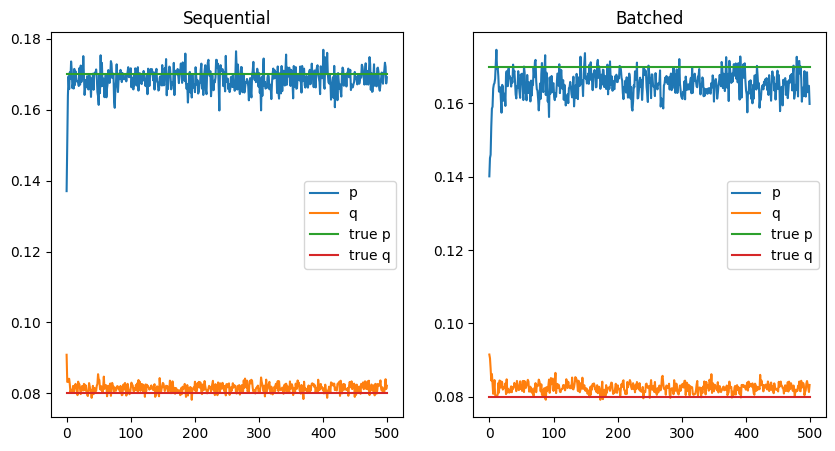

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
# plot the evolution of p and q
plt.title("Sequential")
plt.plot(p_list)
plt.plot(q_list)
# plot the true values of p and q
plt.plot([p] * T)
plt.plot([q] * T)
plt.legend(['p', 'q', 'true p', 'true q'])

plt.subplot(1,2,2)
plt.title("Batched")
plt.plot(p_list_batched)  
plt.plot(q_list_batched)
# plot the true values of p and q
plt.plot([p] * T)
plt.plot([q] * T)
plt.legend(['p', 'q', 'true p', 'true q'])

plt.show()

Check late start average of p,q ("late start posterior mean estimator").

In [8]:
# compute late start averager for p and q
p_late_start = np.mean(p_list[100:])
q_late_start = np.mean(q_list[100:])
p_late_start_batch = np.mean(p_list_batched[100:])
q_late_start_batch = np.mean(q_list_batched[100:])
print("Late start average p: ", p_late_start)
print("Late start p batch: ", p_late_start_batch)
print("True value of p: ", p)
print("Late start average q: ", q_late_start)
print("Late start q batch: ", q_late_start_batch)
print("True value of q: ", q)

Late start average p:  0.16876951038174948
Late start p batch:  0.16538638438141878
True value of p:  0.17
Late start average q:  0.08153242620080245
Late start q batch:  0.08246561224168712
True value of q:  0.08


In [9]:
# more in depth time analysis
import timeit

num = 10

# Define the setup code
setup_code = """
from __main__ import sequential_Gibbs_sampler, batched_Gibbs_sampler, A, z_0, pi_pri, alpha_p_pri, beta_p_pri, alpha_q_pri, beta_q_pri, num_iterations, burn_in
"""

# Define the code for the sequential Gibbs sampler
sequential_code = """
sampler = sequential_Gibbs_sampler(A, z_0, 
                                   alpha_p_pri, beta_p_pri, 
                                   alpha_q_pri, beta_q_pri, 
                                   pi_pri
                                   )
sampler.run(T, burn_in = burn_in)
z_list = sampler.get_z_list()
p_list = sampler.get_p_list()
q_list = sampler.get_q_list()
"""

# Define the code for the batch Gibbs sampler
batch_code = """
batched_sampler = batched_Gibbs_sampler(A, z_0,
                                        alpha_p_pri, beta_p_pri, 
                                        alpha_q_pri, beta_q_pri, 
                                        pi_pri
                                        )
batched_sampler.run(T, burn_in = burn_in)
z_list_batched = batched_sampler.get_z_list()
p_list_batched = batched_sampler.get_p_list()
q_list_batched = batched_sampler.get_q_list()
 """

# # Time the sequential Gibbs sampler
# sequential_time = timeit.timeit(setup=setup_code, stmt=sequential_code, number=num)

# # Time the batch Gibbs sampler
# batch_time = timeit.timeit(setup=setup_code, stmt=batch_code, number=num)
# print("Sequential time: ", sequential_time)
# print("Batch time: ", batch_time)
# print("Time gains: ", sequential_time / batch_time)

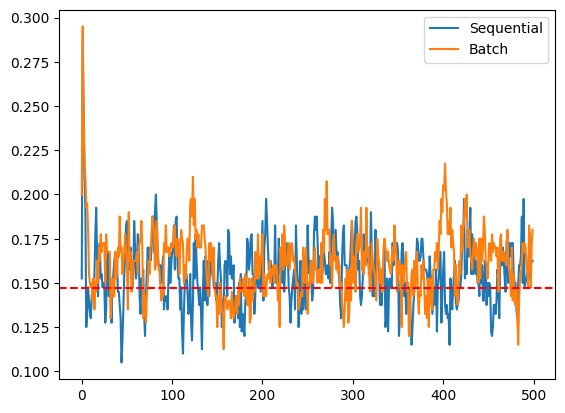

In [10]:
loss_list = [loss(z_true, z_list[i])[0] for i in range(T)]
loss_list_batch = [loss(z_true, z_list_batched[i])[0] for i in range(T)]

plt.plot([loss_list[i] for i in range(T)])
plt.plot([loss_list_batch[i] for i in range(T)])
plt.axhline(y=theoretical_threshold, color='r', linestyle='--')
plt.legend(['Sequential', 'Batch'])
plt.show()

In [11]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# alpha_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
# r = 100
# steps = 50

# # Initialize an empty list to store the loss values
# loss_list = np.zeros((len(alpha_values), r, steps))
# loss_list_batched =  np.zeros((len(alpha_values), r, steps))

# # Loop over each alpha value
# for a in range(len(alpha_values)):
#     alpha = alpha_values[a]
#     z_0 = warm_initializer(z_true, alpha, n ,k)
#     # Run the sampler r times steps iterations
#     for run in range(r):
#         #A, z_true = generate_homogeneous_sbm(n, k, p, q, z_t=z_ex)
#         #z_0 = warm_initializer(z_true, alpha, n ,k)
#         sequential = sequential_Gibbs_sampler(A, z_0, 
#                                    alpha_p_pri, beta_p_pri, 
#                                    alpha_q_pri, beta_q_pri, 
#                                    pi_pri
#                                    )
#         sequential.run(steps, burn_in = 0)
#         z_list = sequential.get_z_list()
#         losses = [loss(z_true, z_list[i])[0] for i in range(steps)]
#         loss_list[a, run, :] = losses
        
#         batched = batched_Gibbs_sampler(A, z_0,
#                                         alpha_p_pri, beta_p_pri, 
#                                         alpha_q_pri, beta_q_pri, 
#                                         pi_pri
#                                         )
#         batched.run(steps, burn_in = 0)
#         z_list_batched = batched.get_z_list()
#         losses_batched = [loss(z_true, z_list_batched[i])[0] for i in range(steps)]
#         loss_list_batched[a, run, :] = losses_batched



In [12]:
# y_lim = 1
# pic = False
# for a in range(len(alpha_values)):
#     df = pd.DataFrame(loss_list[a])
#     df_batched = pd.DataFrame(loss_list_batched[a])
#     alpha = alpha_values[a]
#     print("Alpha: ", alpha)
#     plt.figure(figsize=(10, 6))
#     plt.subplot(1,2,1)
#     plt.title("Sequential")
#     plt.axhline(y=theoretical_threshold, color='r', linestyle='--')
#     df.boxplot()
#     plt.ylim(0, y_lim)
#     plt.subplot(1,2,2)
#     plt.title("Batched")
#     plt.axhline(y=theoretical_threshold, color='r', linestyle='--')
#     df_batched.boxplot()
#     plt.ylim(0, y_lim)
        
#     if pic: plt.savefig(f'det_alpha_{alpha}_r_{r}_steps_{steps}.png')

#     plt.show()

# Trying Neal's code

In [13]:
gamma = 1
alpha = 0.2

In [14]:
A, z_true = generate_homogeneous_sbm(n, k, p, q, z_t=z_ex)
z_0 = warm_initializer(z_true, alpha, n ,k)

In [15]:
from samplers import sequential_Gibbs_sampler
from samplers import batched_Gibbs_sampler

start_time = time.time()

sampler = Neal_sequential_Gibbs_sampler(A, z_0, 
                                   alpha_p_pri, beta_p_pri, 
                                   alpha_q_pri, beta_q_pri, 
                                   gamma = gamma
                                   )
sampler.run(T, burn_in = burn_in)
z_list = sampler.get_z_list()
p_list = sampler.get_p_list()
q_list = sampler.get_q_list()

sequential_time = time.time() - start_time 

start_time = time.time()
batched_sampler = Neal_batched_Gibbs_sampler(A, z_0,
                                        alpha_p_pri, beta_p_pri, 
                                        alpha_q_pri, beta_q_pri, 
                                        gamma = gamma
                                        )
batched_sampler.run(T, burn_in = burn_in)
z_list_batched = batched_sampler.get_z_list()
p_list_batched = batched_sampler.get_p_list()
q_list_batched = batched_sampler.get_q_list()

batched_time = time.time() - start_time

print("Sequential time: ", sequential_time)
print("Batch time: ", batched_time)
print("Time gains: ", sequential_time / batched_time)

100%|██████████| 500/500 [00:07<00:00, 63.38it/s]

Sequential time:  24.89251160621643
Batch time:  7.894587755203247
Time gains:  3.1531110145441117


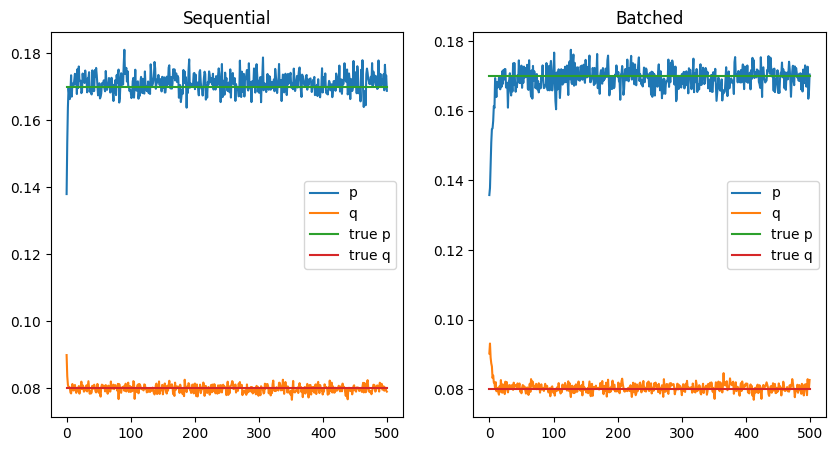

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
# plot the evolution of p and q
plt.title("Sequential")
plt.plot(p_list)
plt.plot(q_list)
# plot the true values of p and q
plt.plot([p] * T)
plt.plot([q] * T)
plt.legend(['p', 'q', 'true p', 'true q'])

plt.subplot(1,2,2)
plt.title("Batched")
plt.plot(p_list_batched)  
plt.plot(q_list_batched)
# plot the true values of p and q
plt.plot([p] * T)
plt.plot([q] * T)
plt.legend(['p', 'q', 'true p', 'true q'])

plt.show()

In [17]:
# compute late start averager for p and q
p_late_start = np.mean(p_list[100:])
q_late_start = np.mean(q_list[100:])
p_late_start_batch = np.mean(p_list_batched[100:])
q_late_start_batch = np.mean(q_list_batched[100:])
print("Late start average p: ", p_late_start)
print("Late start p batch: ", p_late_start_batch)
print("True value of p: ", p)
print("Late start average q: ", q_late_start)
print("Late start q batch: ", q_late_start_batch)
print("True value of q: ", q)

Late start average p:  0.1711533564399138
Late start p batch:  0.16961943153274647
True value of p:  0.17
Late start average q:  0.07982655989287019
Late start q batch:  0.08029081866953883
True value of q:  0.08


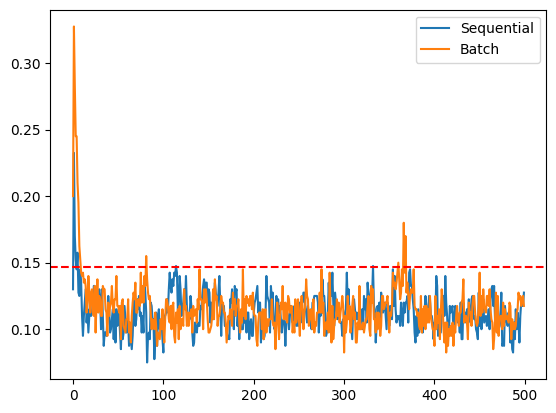

In [19]:
loss_list = [loss(z_true, z_list[i])[0] for i in range(T)]
loss_list_batch = [loss(z_true, z_list_batched[i])[0] for i in range(T)]

plt.plot([loss_list[i] for i in range(T)])
plt.plot([loss_list_batch[i] for i in range(T)])
plt.axhline(y=theoretical_threshold, color='r', linestyle='--')
plt.legend(['Sequential', 'Batch'])
plt.show()